In [1]:
import datasets as ds
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import os
import numpy as np
import nltk
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
nltk.download('wordnet')
nltk.download('omw-1.4')
from yellowbrick.model_selection import FeatureImportances
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import *

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
CUR_DIR = os.path.abspath(os.curdir)
ROOT_DIR = os.path.dirname(CUR_DIR)
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
DATA_DIR = os.path.join(ROOT_DIR, "data")
MODELS_DIR = os.path.join(ROOT_DIR, "models")
MODELS_DIR

'/home/jovyan/projects/vector-nlp/models'

In [3]:
validation_df = pd.read_csv(os.path.join(DATA_DIR,'raw','validation.csv'))
training_df = pd.read_csv(os.path.join(DATA_DIR,'raw','training.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR,'raw','test.csv'))
app_df = pd.concat([validation_df, training_df, test_df])

In [4]:
X = app_df['review']
y = app_df['star']

vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
X_tfidf = vect.fit_transform(X)

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
chi2score = chi2(X_tfidf,y)[0]

wscores = zip(vect.get_feature_names(),chi2score)
wchi2 = sorted(wscores,key=lambda x:x[1]) 
topchi2 = zip(*wchi2[-20:])
show=list(topchi2)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
chi2_selector = SelectKBest(chi2, k=10)
chi2_selector.fit(X_tfidf, y)

# Look at scores returned from the selector for each feature
chi2_scores = pd.DataFrame(list(zip(vect.get_feature_names(), chi2_selector.scores_, chi2_selector.pvalues_)), 
                                       columns=['word', 'score', 'pval'])
chi2_scores.nlargest(20,'score')
chi2_scores.to_csv(os.path.join(DATA_DIR,'output','1.1-Chi-Square-Importance.csv'))

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
chi2_scores

,feature,score,pval
0,00,3.277984,0.512428
1,000,6.135203,0.189276
2,0000,2.089842,0.719239
3,00000,1.493795,0.827740
4,000000,10.018040,0.040125
...,...,...,...
29342,ㅠㅠ,14.997594,0.004706
29343,儿童人3e域名他们就3,20.558073,0.000387
29344,流畅,0.794980,0.939120
29345,简洁,0.794980,0.939120


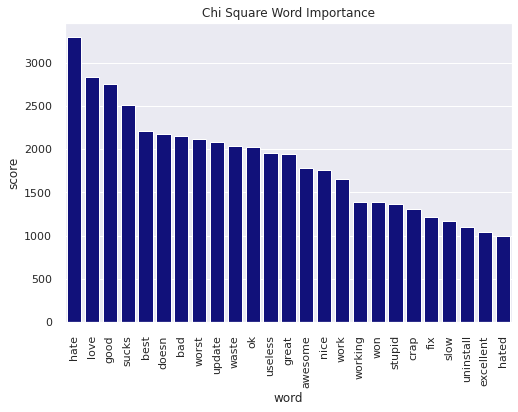

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.title("Chi Square Word Importance")
sns.set_theme(style="darkgrid")
# tips = sns.load_dataset("tips")
ax = sns.barplot(x="word", y="score", data=chi2_scores.nlargest(25,'score'), color='darkblue')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
fig = ax.get_figure()
fig.savefig(f"{IMAGES_DIR}/1.1-Word-Importance.png", bbox_inches = "tight")

In [40]:
app_df.star.value_counts()

5    174374
1     39984
4     37247
3     23196
2     13264
Name: star, dtype: int64

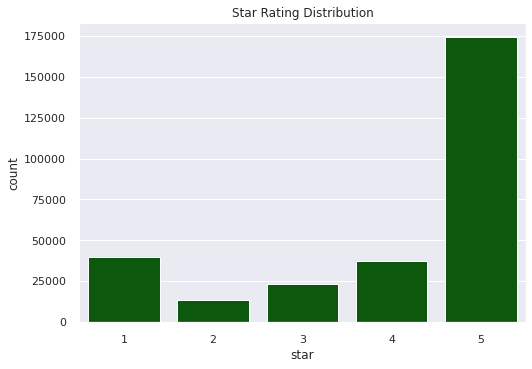

In [37]:
plt.title("Star Rating Distribution")
sns.set_theme(style="darkgrid")
# tips = sns.load_dataset("tips")
ax = sns.countplot(x="star", data=app_df, color='darkgreen')
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
fig = ax.get_figure()
fig.savefig(f"{IMAGES_DIR}/1.1-Score-Distribution.png", bbox_inches = "tight")